# figure 4 (LV)
- loads model fits as produced by LV_fit.ipynb 
- loads evaluation metrics as computed by APT_eval.ipynb on the above model fits
- loads two panel (c, d) produced by the SNL package (python 2) 

In [1]:
%%capture
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import timeit
import os

import delfi.distribution as dd
import delfi.inference as infer
import delfi.generator as dg

from delfi.simulator import TwoMoons
import delfi.summarystats as ds
from delfi.utils.viz import plot_pdf, probs2contours

from lfimodels.snl_exps.util import save_results, load_results
from lfimodels.snl_exps.util import draw_sample_uniform_prior_52, load_gt_lv, init_g_lv
from snl.util.plot import plot_hist_marginals

from inspect import getmembers, isclass

fig_path = 'results/figs/'
fontsize = 16

def rasterize_and_save(fname, rasterize_list=None, fig=None, dpi=None,
                       savefig_kw={}):
    """Save a figure with raster and vector components
    This function lets you specify which objects to rasterize at the export
    stage, rather than within each plotting call. Rasterizing certain
    components of a complex figure can significantly reduce file size.
    Inputs
    ------
    fname : str
        Output filename with extension
    rasterize_list : list (or object)
        List of objects to rasterize (or a single object to rasterize)
    fig : matplotlib figure object
        Defaults to current figure
    dpi : int
        Resolution (dots per inch) for rasterizing
    savefig_kw : dict
        Extra keywords to pass to matplotlib.pyplot.savefig
    If rasterize_list is not specified, then all contour, pcolor, and
    collects objects (e.g., ``scatter, fill_between`` etc) will be
    rasterized
    Note: does not work correctly with round=True in Basemap
    Example
    -------
    Rasterize the contour, pcolor, and scatter plots, but not the line
    >>> import matplotlib.pyplot as plt
    >>> from numpy.random import random
    >>> X, Y, Z = random((9, 9)), random((9, 9)), random((9, 9))
    >>> fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
    >>> cax1 = ax1.contourf(Z)
    >>> cax2 = ax2.scatter(X, Y, s=Z)
    >>> cax3 = ax3.pcolormesh(Z)
    >>> cax4 = ax4.plot(Z[:, 0])
    >>> rasterize_list = [cax1, cax2, cax3]
    >>> rasterize_and_save('out.svg', rasterize_list, fig=fig, dpi=300)
    """

    # Behave like pyplot and act on current figure if no figure is specified
    fig = plt.gcf() if fig is None else fig

    # Need to set_rasterization_zorder in order for rasterizing to work
    zorder = -5  # Somewhat arbitrary, just ensuring less than 0

    if rasterize_list is None:
        # Have a guess at stuff that should be rasterised
        types_to_raster = ['QuadMesh', 'Contour', 'collections']
        rasterize_list = []

        print("""
        No rasterize_list specified, so the following objects will
        be rasterized: """)
        # Get all axes, and then get objects within axes
        for ax in fig.get_axes():
            for item in ax.get_children():
                if any(x in str(item) for x in types_to_raster):
                    rasterize_list.append(item)
        print('\n'.join([str(x) for x in rasterize_list]))
    else:
        # Allow rasterize_list to be input as an object to rasterize
        if type(rasterize_list) != list:
            rasterize_list = [rasterize_list]

    for item in rasterize_list:

        # Whether or not plot is a contour plot is important
        is_contour = (isinstance(item, matplotlib.contour.QuadContourSet) or
                      isinstance(item, matplotlib.tri.TriContourSet))

        # Whether or not collection of lines
        # This is commented as we seldom want to rasterize lines
        # is_lines = isinstance(item, matplotlib.collections.LineCollection)

        # Whether or not current item is list of patches
        all_patch_types = tuple(
            x[1] for x in getmembers(matplotlib.patches, isclass))
        try:
            is_patch_list = isinstance(item[0], all_patch_types)
        except TypeError:
            is_patch_list = False

        # Convert to rasterized mode and then change zorder properties
        if is_contour:
            curr_ax = item.ax.axes
            curr_ax.set_rasterization_zorder(zorder)
            # For contour plots, need to set each part of the contour
            # collection individually
            for contour_level in item.collections:
                contour_level.set_zorder(zorder - 1)
                contour_level.set_rasterized(True)
        elif is_patch_list:
            # For list of patches, need to set zorder for each patch
            for patch in item:
                curr_ax = patch.axes
                curr_ax.set_rasterization_zorder(zorder)
                patch.set_zorder(zorder - 1)
                patch.set_rasterized(True)
        else:
            # For all other objects, we can just do it all at once
            curr_ax = item.axes
            curr_ax.set_rasterization_zorder(zorder)
            item.set_rasterized(True)
            item.set_zorder(zorder - 1)

    # dpi is a savefig keyword argument, but treat it as special since it is
    # important to this function
    if dpi is not None:
        savefig_kw['dpi'] = dpi

    # Save resulting figure
    fig.savefig(fname, **savefig_kw)


# panel (a)

sampling, (itercount, n_drawn) =  (1, 5000)


/home/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


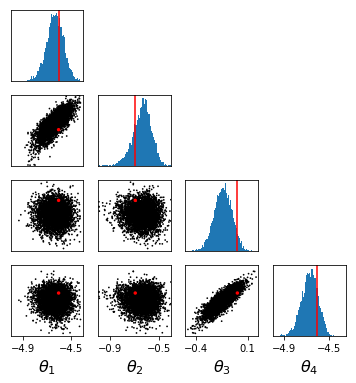

In [2]:
save_path = 'results/lv_validationset/'

plot_seed = 43
exp_id = 'seed' + str(plot_seed)
log, tds, posteriors, _ = load_results(exp_id=exp_id, path=save_path)
pars_true, obs_stats = load_gt_lv(init_g_lv(seed=plot_seed))


lims = [ [-5, -4.4], [-1.0, -0.4], [-0.5, 0.2], [-5, -4.35] ] 
pnl_a = plot_hist_marginals(draw_sample_uniform_prior_52(posteriors[-1],5000), lims=lims, gt=pars_true.flatten())
pnl_a.set_figwidth(6)
pnl_a.set_figheight(6)
for ax in pnl_a.axes:
    ax.set_xticks([])
    ax.set_yticks([])
#    ax.axis('off')
    
pnl_a.axes[-4].set_xlabel(r'$\theta_1$', fontsize=fontsize)
pnl_a.axes[-3].set_xlabel(r'$\theta_2$', fontsize=fontsize)
pnl_a.axes[-2].set_xlabel(r'$\theta_3$', fontsize=fontsize)    
pnl_a.axes[-1].set_xlabel(r'$\theta_4$', fontsize=fontsize)        
    
PANEL_3A = fig_path +'fig4_a.svg'

pnl_a.axes[6].set_xticks([-4.9, -4.5])
pnl_a.axes[7].set_xticks([-0.9, -0.5])
pnl_a.axes[8].set_xticks([-0.4, 0.1])
pnl_a.axes[9].set_xticks([-4.9, -4.5])

savefig_kw = {
'facecolor' : plt.gcf().get_facecolor(), 
'transparent' : True,
'bbox_inches' : 'tight' 
}

rasterize_and_save(PANEL_3A, rasterize_list=[pnl_a.axes[i] for i in [1,3,4,6,7,8]], fig=pnl_a, dpi=600, savefig_kw=savefig_kw)

# panel (b)

pars_true :  [-4.60517019 -0.69314718  0.         -4.60517019]


/home/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


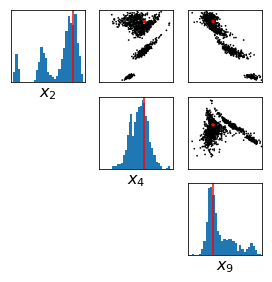

In [3]:
from delfi.distribution.PointMass import PointMass
from lfimodels.snl_exps.util import init_g_lv as init_g
from lfimodels.snl_exps.util import load_gt_lv as load_gt


save_path = 'results/lv_validationset/'

plot_seed = 42

pars_true, obs_stats = load_gt(generator=init_g(seed=plot_seed))
print('pars_true : ', pars_true)

g = init_g(seed=plot_seed+1)
g.prior = PointMass(loc=pars_true)

try:
    x_samples
except:
    _, x_samples = g.gen(1000)
idx = np.array([1,3,8])
idx_x = np.where(x_samples[:, idx][:,0] < 60 )[0]
pnl_a_inset = plot_hist_marginals(x_samples[np.ix_(idx_x, idx)], 
                                  lims=[[7, 60],[5,10],[-0.3,0.65]], gt=obs_stats[0,idx].flatten(), upper=True)
pnl_a_inset.set_figwidth(4.5)
pnl_a_inset.set_figheight(4.5)
for ax in pnl_a_inset.axes:
    ax.set_xticks([])
    ax.set_yticks([])
pnl_a_inset.axes[0].set_xlabel(r'$x_2$', fontsize=fontsize)
pnl_a_inset.axes[3].set_xlabel(r'$x_4$', fontsize=fontsize)
pnl_a_inset.axes[5].set_xlabel(r'$x_9$', fontsize=fontsize)
    
PANEL_3Ainset = fig_path +'fig4_ai.svg'

savefig_kw = {
'facecolor' : plt.gcf().get_facecolor(), 
'transparent' : True,
'bbox_inches' : 'tight' 
}

rasterize_and_save(PANEL_3Ainset, rasterize_list=[pnl_a_inset.axes[i] for i in [1,2,4]], fig=pnl_a_inset, dpi=600, savefig_kw=savefig_kw)

#plt.savefig(PANEL_3Ainset, facecolor=plt.gcf().get_facecolor(), transparent=True)
    
pnl_a_inset.show()

In [4]:
PANEL_3Ainset = fig_path +'fig4_ai.svg'


In [5]:
# e.g. Lotka-Volterra raw traces, with color-coded trace segments used for specific fits

# panel (c)

In [6]:
PANEL_3C = fig_path +'lv_lprobs_validationset.svg'

# panel (d)

In [7]:
PANEL_3D = fig_path +'lv_dists_validationset.svg'

# assemble figure

In [8]:
%run -i ./common.ipynb

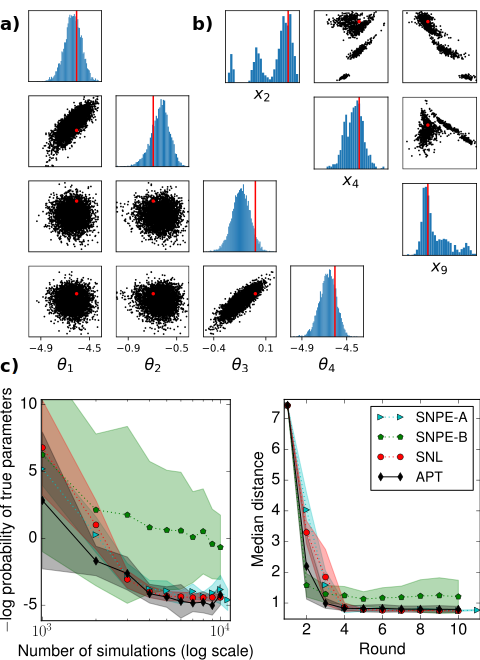

In [9]:
# FIGURE and GRID
FIG_HEIGHT_MM = 110
FIG_WIDTH_MM = 80  # set in NIPS2017 notebook to a default value for all figures

FIG_N_ROWS = 2
ROW_1_NCOLS = 2
ROW_1_HEIGHT_MM =      1.2 * (FIG_HEIGHT_MM / FIG_N_ROWS )
ROW_1_WIDTH_COL_1_MM =  1.5* (FIG_WIDTH_MM / ROW_1_NCOLS)

ROW_2_NCOLS = 2
ROW_2_HEIGHT_MM = 0.8 * FIG_HEIGHT_MM / FIG_N_ROWS
ROW_2_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_2_NCOLS
ROW_2_WIDTH_COL_2_MM = FIG_WIDTH_MM / ROW_2_NCOLS


fig = create_fig(FIG_WIDTH_MM, FIG_HEIGHT_MM)


fig = add_svg(fig, PANEL_3A, 
              3, 
              0)
fig = add_label(fig, 
                'a)', 
                0, 
                5)
fig = add_svg(fig, PANEL_3Ainset, 
              35.8, 
              0)
fig = add_label(fig, 
                'b)', 
                32, 
                5)

fig = add_svg(fig, PANEL_3C, 
              1.8,
              62) 
fig = add_label(fig, 
                'c)', 
                0, 
                62)

fig = add_svg(fig, PANEL_3D, 
                42.1, 
                62)


if False:
    fig = add_grid(fig, 2, 2)
    fig = add_grid(fig, 160/3, 10, font_size_px=0.0001)


PATH_SVG = PATH_DROPBOX_FIGS + 'fig4.svg'
fig.save(PATH_SVG)
svg(PATH_SVG)
!$INKSCAPE --export-pdf $PATH_DROPBOX_FIGS/fig4.pdf $PATH_SVG
